# Exploring Polynomial Features with Regularization

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plb 
%matplotlib inline

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

## Data Import & Setup

In [2]:
sf = pd.read_csv('data_files/sf_clean.csv')

# Reformatting hood_district names
sf['hood_district'] = sf['hood_district'].astype(int)
sf['hood_district'] = sf['hood_district'].astype(str)

In [3]:
sf = sf[sf['price'] < 6000]

In [4]:
laundry_dict = {'(a) in-unit': 2, 
               '(b) on-site': 1,
               '(c) no laundry': 0}

sf = sf.replace({'laundry': laundry_dict})

In [5]:
parking_dict = {'(a) valet': 3, 
               '(b) protected': 2,
               '(c) off-street': 1,
               '(d) no parking': 0}

sf = sf.replace({'parking': parking_dict})

In [6]:
pets_dict = {'(a) both': 1, 
            '(b) dogs': 1,
            '(c) cats': 1,
            '(d) no pets': 0}

sf = sf.replace({'pets': pets_dict})

In [7]:
#sf = sf.drop(['pets'], axis=1)
sf = sf.drop(['housing_type'], axis=1)

In [8]:
sf = pd.get_dummies(sf)
sf = sf.drop(['hood_district_10'], axis=1)

In [9]:
sf.price.describe()

count     936.00000
mean     3345.28953
std      1031.37558
min       750.00000
25%      2600.00000
50%      3200.00000
75%      3995.00000
max      5995.00000
Name: price, dtype: float64

## Train / Test Split

In [10]:
X, y = sf.drop('price',axis=1), sf['price']

# Training versus Test Data
# hold out 20% of the data for testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.25, random_state=5)

# Training versus Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

## Polynomial Features Set Up

In [11]:
poly = PolynomialFeatures(degree=2, interaction_only=False)
    
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

In [12]:
# Scaling for Ridge & Lasso 
scaler = StandardScaler(with_mean=False)

X_train_scaled = scaler.fit_transform(X_train_poly)
X_val_scaled = scaler.transform(X_val_poly)
X_test_scaled = scaler.transform(X_test_poly)

## Lasso

In [13]:
alphavec = 10**np.linspace(-2,2,1000)

lasso_model = LassoCV(alphas=alphavec, cv=5)
lasso_model.fit(X_train_scaled, y_train)

/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55525.58886311948, tolerance: 45286.37880665083
  model = cd_fast.enet_coordinate_descent_gram(
/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69505.32064059377, tolerance: 45286.37880665083
  model = cd_fast.enet_coordinate_descent_gram(
/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81531.55607911944, tolerance: 45286.37880665083
  model = cd_fast.enet_coordinate_descent_gram(
/Users/scrapf

/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6145965.683140859, tolerance: 45286.37880665083
  model = cd_fast.enet_coordinate_descent_gram(
/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6440354.119747676, tolerance: 45286.37880665083
  model = cd_fast.enet_coordinate_descent_gram(
/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6731384.027112097, tolerance: 45286.37880665083
  model = cd_fast.enet_coordinate_descent_gram(
/Users/scrapf

/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159241.42378479242, tolerance: 44921.799196199536
  model = cd_fast.enet_coordinate_descent_gram(
/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169940.11085090786, tolerance: 44921.799196199536
  model = cd_fast.enet_coordinate_descent_gram(
/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179531.30892258137, tolerance: 44921.799196199536
  model = cd_fast.enet_coordinate_descent_gram(
/Users/

/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229971.99412687123, tolerance: 44921.799196199536
  model = cd_fast.enet_coordinate_descent_gram(
/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 234734.50756906718, tolerance: 44921.799196199536
  model = cd_fast.enet_coordinate_descent_gram(
/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238932.0553588271, tolerance: 44921.799196199536
  model = cd_fast.enet_coordinate_descent_gram(
/Users/s

/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154585.3772232756, tolerance: 44921.799196199536
  model = cd_fast.enet_coordinate_descent_gram(
/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170919.96679376066, tolerance: 44921.799196199536
  model = cd_fast.enet_coordinate_descent_gram(
/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 185813.919340536, tolerance: 44921.799196199536
  model = cd_fast.enet_coordinate_descent_gram(
/Users/scr

/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 310057.44739466906, tolerance: 44921.799196199536
  model = cd_fast.enet_coordinate_descent_gram(
/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 314790.0172456056, tolerance: 44921.799196199536
  model = cd_fast.enet_coordinate_descent_gram(
/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318958.9994201958, tolerance: 44921.799196199536
  model = cd_fast.enet_coordinate_descent_gram(
/Users/sc

LassoCV(alphas=array([1.00000000e-02, 1.00926219e-02, 1.01861017e-02, 1.02804473e-02,
       1.03756668e-02, 1.04717682e-02, 1.05687597e-02, 1.06666496e-02,
       1.07654461e-02, 1.08651577e-02, 1.09657929e-02, 1.10673602e-02,
       1.11698682e-02, 1.12733256e-02, 1.13777413e-02, 1.14831241e-02,
       1.15894830e-02, 1.16968270e-02, 1.18051653e-02, 1.19145070e-02,
       1.20248614e-02, 1.21362380e-0...
       8.08924349e+01, 8.16416760e+01, 8.23978568e+01, 8.31610415e+01,
       8.39312950e+01, 8.47086827e+01, 8.54932707e+01, 8.62851257e+01,
       8.70843150e+01, 8.78909065e+01, 8.87049689e+01, 8.95265713e+01,
       9.03557835e+01, 9.11926760e+01, 9.20373200e+01, 9.28897872e+01,
       9.37501502e+01, 9.46184819e+01, 9.54948564e+01, 9.63793480e+01,
       9.72720319e+01, 9.81729841e+01, 9.90822810e+01, 1.00000000e+02]),
        cv=5)

In [14]:
las_alpha = lasso_model.alpha_
las_alpha

1.3125568357718427

In [15]:
las = Lasso(alpha=las_alpha)

las.fit(X_train_scaled, y_train)
print(f'Lasso Regression train R^2: {las.score(X_train_scaled, y_train):.5f}')
print(f'Lasso Regression val R^2: {las.score(X_val_scaled, y_val):.5f}')
print("")
print(f'Lasso Regression RMSE (train): {mean_squared_error(y_train, las.predict(X_train_scaled), squared=False):.5f}')
print(f'Lasso Regression RMSE (val): {mean_squared_error(y_val, las.predict(X_val_scaled), squared=False):.5f}')

Lasso Regression train R^2: 0.83414
Lasso Regression val R^2: 0.74410

Lasso Regression RMSE (train): 423.74596
Lasso Regression RMSE (val): 495.77983


## Ridge

In [16]:
alphavec = 10**np.linspace(-2,2,500)

ridge_model = RidgeCV(alphas=alphavec, cv=3)
ridge_model.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.01862899e-02, 1.03760502e-02, 1.05693455e-02,
       1.07662418e-02, 1.09668060e-02, 1.11711065e-02, 1.13792129e-02,
       1.15911962e-02, 1.18071285e-02, 1.20270833e-02, 1.22511358e-02,
       1.24793621e-02, 1.27118400e-02, 1.29486487e-02, 1.31898690e-02,
       1.34355829e-02, 1.36858742e-02, 1.39408283e-02, 1.42005318e-02,
       1.44650734e-02, 1.47345431e-0...
       6.54080591e+01, 6.66265452e+01, 6.78677305e+01, 6.91320378e+01,
       7.04198979e+01, 7.17317494e+01, 7.30680395e+01, 7.44292233e+01,
       7.58157646e+01, 7.72281357e+01, 7.86668179e+01, 8.01323013e+01,
       8.16250851e+01, 8.31456781e+01, 8.46945981e+01, 8.62723729e+01,
       8.78795401e+01, 8.95166472e+01, 9.11842520e+01, 9.28829225e+01,
       9.46132376e+01, 9.63757866e+01, 9.81711702e+01, 1.00000000e+02]),
        cv=3)

In [17]:
rid_alpha = ridge_model.alpha_
rid_alpha

6.881376986415663

In [19]:
rid = Ridge(alpha=rid_alpha)

rid.fit(X_train_scaled, y_train)
print(f'Ridge Regression train R^2: {rid.score(X_train_scaled, y_train):.5f}')
print(f'Ridge Regression val R^2: {rid.score(X_val_scaled, y_val):.5f}')
print("")
print(f'Ridge Regression RMSE (train): {mean_squared_error(y_train, rid.predict(X_train_scaled), squared=False):.5f}')
print(f'Ridge Regression RMSE (val): {mean_squared_error(y_val, rid.predict(X_val_scaled), squared=False):.5f}')

Ridge Regression train R^2: 0.83115
Ridge Regression val R^2: 0.74344

Ridge Regression RMSE (train): 427.54008
Ridge Regression RMSE (val): 496.42742


## Cross Validation & Comparison

In [20]:
sf2 = sf.copy()

In [21]:
X, y = sf2.drop('price',axis=1), sf2['price']

# Training versus Test Data
# hold out 20% of the data for testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.25, random_state=6)

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state = 17)

cv_rid_train_r2s, cv_las_train_r2s = [], []
cv_rid_val_r2s, cv_las_val_r2s = [], []

rid_rmses_train, las_rmses_train = [], []
rid_rmses_val, las_rmses_val = [], []

X_kf, y_kf = np.array(X), np.array(y)

for train_ind, val_ind in kf.split(X, y):
    
    X_train, y_train = X_kf[train_ind], y_kf[train_ind]
    X_val, y_val = X_kf[val_ind], y_kf[val_ind]
    
    # Set up poly features
    poly = PolynomialFeatures(degree=2, interaction_only=False)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Scaling for Ridge & Lasso 
    scaler = StandardScaler(with_mean=False)
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_val_scaled = scaler.transform(X_val_poly)
    
    # Lasso
    las = Lasso(alpha=las_alpha)
    las.fit(X_train_scaled, y_train)
    
    cv_las_train_r2s.append(las.score(X_train_scaled, y_train))
    cv_las_val_r2s.append(las.score(X_val_scaled, y_val))
    las_rmses_train.append(mean_squared_error(y_train, las.predict(X_train_scaled), squared=False))
    las_rmses_val.append(mean_squared_error(y_val, las.predict(X_val_scaled), squared=False))
    
    # Ridge
    rid = Ridge(alpha=rid_alpha)
    rid.fit(X_train_scaled, y_train)
    
    cv_rid_train_r2s.append(rid.score(X_train_scaled, y_train))
    cv_rid_val_r2s.append(rid.score(X_val_scaled, y_val))
    rid_rmses_train.append(mean_squared_error(y_train, rid.predict(X_train_scaled), squared=False))
    rid_rmses_val.append(mean_squared_error(y_val, rid.predict(X_val_scaled), squared=False))

# Summary output

print("Ridge")
print(f'Ridge mean cv r^2 (TRAIN): {np.mean(cv_rid_train_r2s):.5f} +- {np.std(cv_rid_train_r2s):.5f}')
print(f'Ridge mean cv r^2 (VAL): {np.mean(cv_rid_val_r2s):.5f} +- {np.std(cv_rid_val_r2s):.5f}')
print(f'Ridge mean RMSE (TRAIN): {np.mean(rid_rmses_train):.5f} +- {np.std(rid_rmses_train):.3f}')
print(f'Ridge mean RMSE (VAL): {np.mean(rid_rmses_train):.5f} +- {np.std(rid_rmses_train):.3f}')
print('')
print("Lasso")
print(f'Lasso mean cv r^2 (TRAIN): {np.mean(cv_las_train_r2s):.5f} +- {np.std(cv_las_train_r2s):.5f}')
print(f'Lasso mean cv r^2 (VAL): {np.mean(cv_las_val_r2s):.5f} +- {np.std(cv_las_val_r2s):.5f}')
print(f'Lasso mean RMSE (VAL): {np.mean(las_rmses_train):.5f} +- {np.std(las_rmses_train):.5f}')
print(f'Lasso mean RMSE (VAL): {np.mean(las_rmses_val):.5f} +- {np.std(las_rmses_val):.5f}')    

Ridge
Ridge mean cv r^2 (TRAIN): 0.80235 +- 0.00675
Ridge mean cv r^2 (VAL): 0.72527 +- 0.04001
Ridge mean RMSE (TRAIN): 448.35445 +- 10.945
Ridge mean RMSE (VAL): 448.35445 +- 10.945

Lasso
Lasso mean cv r^2 (TRAIN): 0.80297 +- 0.00653
Lasso mean cv r^2 (VAL): 0.72528 +- 0.03732
Lasso mean RMSE (VAL): 447.65083 +- 10.85273
Lasso mean RMSE (VAL): 524.04752 +- 48.44162


In [23]:
sf2.head()

,price,sqft,beds,bath,laundry,pets,parking,hood_district_1,hood_district_2,hood_district_3,hood_district_4,hood_district_5,hood_district_6,hood_district_7,hood_district_8,hood_district_9
1,3500,550.0,1.0,1.0,2,1,2,0,0,0,0,0,0,1,0,0
2,5100,1300.0,2.0,1.0,2,1,0,0,0,0,0,0,0,1,0,0
4,3100,561.0,1.0,1.0,0,1,0,0,0,0,0,0,0,1,0,0
5,3800,800.0,2.0,1.0,1,1,2,0,0,0,0,0,0,0,0,1
6,3100,750.0,1.0,1.0,2,0,2,0,0,0,0,0,0,0,1,0


In [24]:
rid_coefs = rid.coef_
las_coefs = las.coef_

features = sf2.columns[1:]

coef_data = {'Features': poly.get_feature_names(X.columns),
             'Ridge': rid_coefs,
             'Lasso': las_coefs}

coef_df = pd.DataFrame(coef_data)

In [25]:
#coef_df[:50]

In [26]:
#coef_df[50:100]

In [27]:
#coef_df[100:]

# Stats Models

In [28]:
# poly = PolynomialFeatures(degree=2, interaction_only=False)
    
# X_train_poly = poly.fit_transform(X)
# X_test_poly = poly.transform(X_test)

# # Scaling for Ridge & Lasso 
# scaler = StandardScaler(with_mean=False)

# X_train_scaled = scaler.fit_transform(X_train_poly)
# X_test_scaled = scaler.transform(X_test_poly)

In [29]:
# coef_df[:50]

In [30]:
# model = sm.OLS(y, sm.add_constant(X_train_scaled))
# results = model.fit()

# results.summary()

# RIDGE: Full Train and Test

In [31]:
poly = PolynomialFeatures(degree=2, interaction_only=False)
    
X_train_poly = poly.fit_transform(X)
X_test_poly = poly.transform(X_test)

# Scaling for Ridge & Lasso 
scaler = StandardScaler(with_mean=False)

X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

In [32]:
rid = Ridge(alpha=rid_alpha)
rid.fit(X_train_scaled, y)

Ridge(alpha=6.881376986415663)

In [33]:
print("Ridge - training score: ", rid.score(X_train_scaled, y))
print("Rige - test score: ", rid.score(X_test_scaled, y_test))
print("")
print("RMSE - training: ", mean_squared_error(y, rid.predict(X_train_scaled), squared=False))
print("RMSE - test: ", mean_squared_error(y_test, rid.predict(X_test_scaled), squared=False))

Ridge - training score:  0.7959843301000518
Rige - test score:  0.816917518878142

RMSE - training:  455.76294353583376
RMSE - test:  463.9632772503655


In [34]:
rid_predict = rid.predict(X_test_scaled)

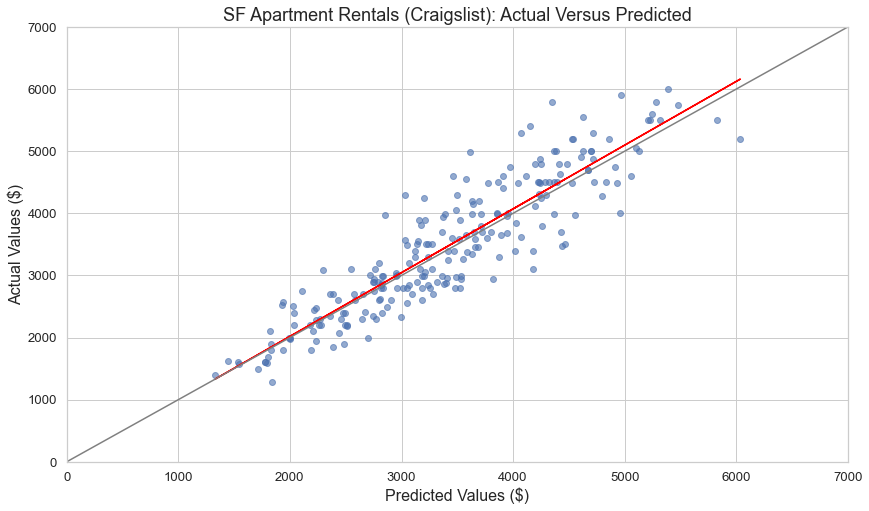

In [35]:
plt.figure(figsize=(14, 8))
plt.scatter(rid_predict, y_test, alpha=.6) 

z = np.polyfit(rid_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(rid_predict, p(rid_predict), 'm-', color='red')
plt.plot(np.linspace(0,7000,1000), np.linspace(0,7000,1000), color='grey')

plt.xlim(0, 7000)
plt.ylim(0, 7000)

plt.title('SF Apartment Rentals (Craigslist): Actual Versus Predicted', fontsize=18, fontname='Arial')
plt.xlabel('Predicted Values ($)', fontsize=16, fontname='Arial')
plt.ylabel('Actual Values ($)', fontsize=16, fontname='Arial');

#plt.savefig('img/actual_predicted.png');

In [36]:
rid_residual = (y_test - rid_predict)

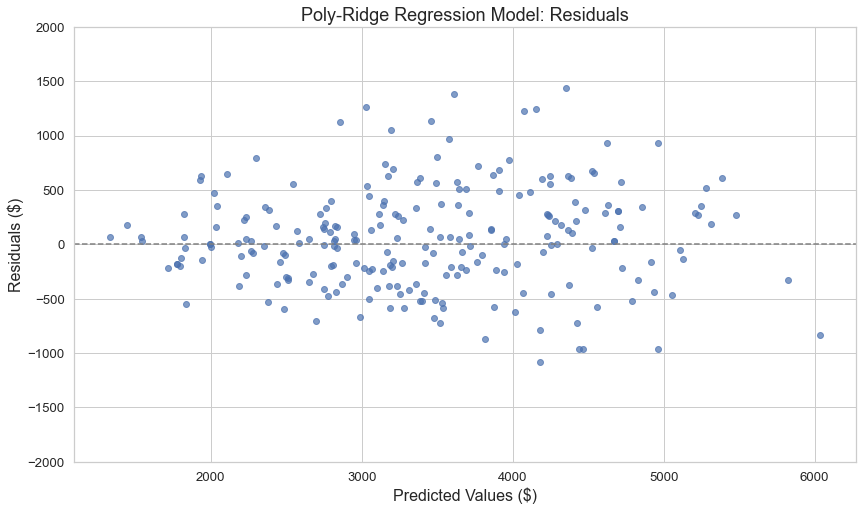

In [37]:
plt.figure(figsize=(14, 8))
plt.scatter(rid_predict, rid_residual, alpha=.7)   

plt.axhline(0, linestyle='--', color='grey')
plt.title('Poly-Ridge Regression Model: Residuals', fontsize=18, fontname='Arial')
plt.ylim(-2000, 2000)
plt.xlabel('Predicted Values ($)', fontsize=16, fontname='Arial')
plt.ylabel('Residuals ($)', fontsize=16, fontname='Arial');

#plt.savefig('img/residuals.png');

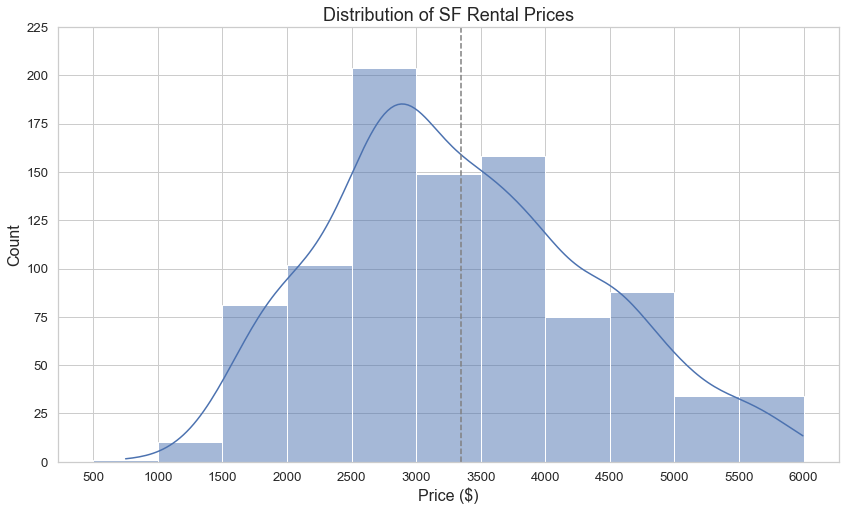

In [38]:
plt.figure(figsize=(14, 8))
ax_actual = sns.histplot(sf.price, kde=True, bins=(list(range(500, 6001, 500))))
plt.axvline(sf.price.mean(), linestyle='--', color='grey')
#ax_predict = sns.histplot(rid_predict, kde=True)
ax_actual.set_title('Distribution of SF Rental Prices', fontname='Arial', fontsize=18)
ax_actual.set_xlabel('Price ($)', fontname='Arial', fontsize=16)
ax_actual.set_ylabel('Count', fontname='Arial', fontsize=16)
ax_actual.set_yticks([0, 25, 50, 75, 100, 125, 150, 175, 200, 225])
ax_actual.set_xticks(list(range(500, 6001, 500)))
ax_actual.set_xticklabels(list(range(500, 6001, 500)));

#plt.savefig('img/distribution.png')

/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


TypeError: 'float' object cannot be interpreted as an integer

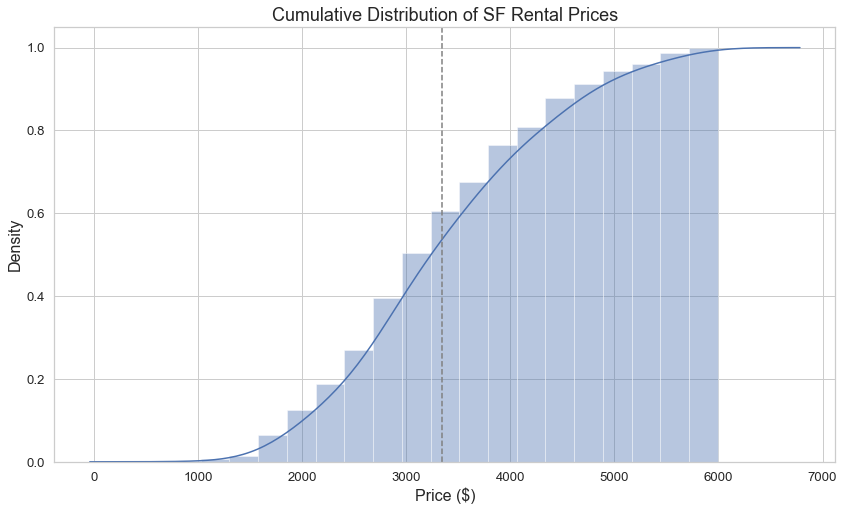

In [39]:
x = sf.price
kwargs= {'cumulative': True}

plt.figure(figsize=(14, 8))
dist = sns.distplot(x, hist_kws=kwargs, kde_kws=kwargs)
plt.axvline(sf.price.mean(), linestyle='--', color='grey')

dist.set_title('Cumulative Distribution of SF Rental Prices', fontname='Arial', fontsize=18)
dist.set_xlabel('Price ($)', fontname='Arial', fontsize=16)
dist.set_ylabel('Density', fontname='Arial', fontsize=16)
dist.set_yticks(list(range(0., 1., .2)))
dist.set_xticks(list(range(500, 6501, 500)))
dist.set_xticklabels(list(range(500, 6501, 500)));

#plt.savefig('img/price_cdf.png')

/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


TypeError: 'float' object cannot be interpreted as an integer

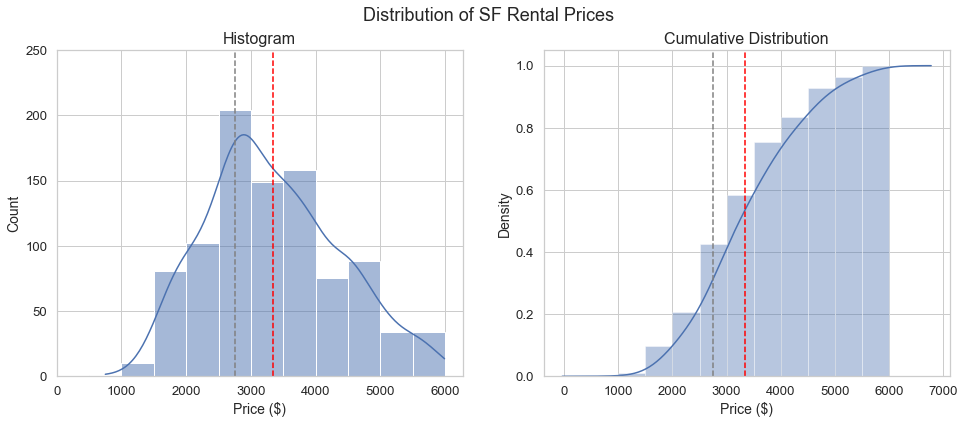

In [77]:
from scipy import stats

x = sf.price
x_mode = stats.mode(x)

plt.figure(figsize=(16, 6))
plt.suptitle('Distribution of SF Rental Prices', fontname='Arial', fontsize=18)

plt.subplot(1, 2, 1)
ax_actual = sns.histplot(sf.price, kde=True, bins=(list(range(500, 6001, 500))))
ax_actual.set_title('Histogram', fontname='Arial', fontsize=16)
ax_actual.set_xlabel('Price ($)', fontname='Arial', fontsize=14)
ax_actual.set_ylabel('Count', fontname='Arial', fontsize=14)
ax_actual.set_yticks([0, 50, 100, 150, 200, 250])
ax_actual.set_xticks(list(range(0, 6001, 1000)))
ax_actual.set_xticklabels(list(range(0, 6001, 1000)))
plt.axvline(sf.price.mean(), linestyle='--', color='red')
plt.axvline(2750, linestyle='--', color='grey')

plt.subplot(1, 2, 2)
kwargs= {'cumulative': True}
dist = sns.distplot(x, hist_kws=kwargs, kde_kws=kwargs, bins=(list(range(500, 6001, 500))))
plt.axvline(x.mean(), linestyle='--', color='red')
plt.axvline(2750, linestyle='--', color='grey')

dist.set_title('Cumulative Distribution', fontname='Arial', fontsize=16)
dist.set_xlabel('Price ($)', fontname='Arial', fontsize=14)
dist.set_ylabel('Density', fontname='Arial', fontsize=14)
dist.set_yticks(list(range(0., 1., .2)))
dist.set_xticks(list(range(500, 6501, 1000)))
dist.set_xticklabels(list(range(500, 6501, 1000)));

#plt.savefig('img/price_hist_cdf.png')

In [60]:
mae = np.mean(np.abs(rid_predict - y_test))
mae

361.2418297079297